### Importing required libraries:

In [1]:
from scipy.stats import norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn import tree 
from sklearn import preprocessing
from sklearn import metrics
from sklearn import feature_selection
from sklearn import neighbors
from sklearn import ensemble
from sklearn import naive_bayes

#### Setting the size of the plots:

In [2]:
plt.rcParams['figure.figsize']=(10,7)

### Creating a dataset:

In [5]:
terr_df=pd.read_excel("/home/amartya/Documents/Machine-Learning/datasets/Project/Project_Dataset.xlsm")
terr_df.info()
terr_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43915 entries, 0 to 43914
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   iyear             43915 non-null  int64  
 1   imonth            43915 non-null  int64  
 2   iday              43915 non-null  int64  
 3   country_txt       43915 non-null  object 
 4   city              43915 non-null  object 
 5   attacktype1_txt   43915 non-null  object 
 6   targtype1_txt     43915 non-null  object 
 7   corp1             43915 non-null  object 
 8   target1           43915 non-null  object 
 9   natlty1_txt       43342 non-null  object 
 10  gname             43915 non-null  object 
 11  weaptype1_txt     43915 non-null  object 
 12  weapsubtype1_txt  39346 non-null  object 
 13  weapdetail        16985 non-null  object 
 14  nkill             41290 non-null  float64
 15  nwound            39313 non-null  float64
 16  propextent_txt    15615 non-null  object

,iyear,imonth,iday,country_txt,city,attacktype1_txt,targtype1_txt,corp1,target1,natlty1_txt,gname,weaptype1_txt,weapsubtype1_txt,weapdetail,nkill,nwound,propextent_txt,ransomamt
0,2012,1,1,Kenya,Garissa,Armed Assault,Business,Locus Pub,Bar,Kenya,Al-Shabaab,Explosives/Bombs/Dynamite,Grenade,Two grenades and AK-47 assault rifles were use...,3.0,14.0,Minor (likely < $1 million),NaN
1,2012,1,1,Pakistan,Sui,Bombing/Explosion,Military,Frontier Corps (FC),Soldiers,Pakistan,Baloch Republican Army (BRA),Explosives/Bombs/Dynamite,Land Mine,NaN,4.0,3.0,Minor (likely < $1 million),NaN
2,2012,1,1,Kenya,Garissa,Armed Assault,Business,Unknown,Bar,Kenya,Al-Shabaab,Explosives/Bombs/Dynamite,Grenade,NaN,2.0,14.0,Minor (likely < $1 million),NaN
3,2012,1,1,Afghanistan,Karez,Bombing/Explosion,Military,North Atlantic Treaty Organization (NATO): Int...,Vehicle,International,Taliban,Explosives/Bombs/Dynamite,Unknown Explosive Type,NaN,0.0,0.0,Unknown,NaN
4,2012,1,1,Democratic Republic of the Congo,Shabunda,Facility/Infrastructure Attack,Private Citizens & Property,Not Applicable,Civilians,Democratic Republic of the Congo,Democratic Front for the Liberation of Rwanda ...,Incendiary,Arson/Fire,NaN,18.0,5.0,Minor (likely < $1 million),NaN


In [6]:
terr_df.nunique()

iyear                   5
imonth                 12
iday                   31
country_txt           125
city                13203
attacktype1_txt         9
targtype1_txt          22
corp1                7632
target1             11783
natlty1_txt           146
gname                 769
weaptype1_txt          11
weapsubtype1_txt       28
weapdetail           6042
nkill                 144
nwound                148
propextent_txt          3
ransomamt             164
dtype: int64

### Glancing at the dataset, we can draw the following conclusions:
- There are many terrorist organisations,769 of them to be exact, but not all of them are equally notorious.
- Date,month,year are given in different columns,which is not needed.
- "weapdetail","corp1","target1","city" are actually proper nouns with very high number of unique values.
- There are some columns with 'nan' values.

### Dropping columns with high unique value count:

In [7]:
terr_df.drop(["weapdetail","corp1","target1"],axis=1,inplace=True)

### Dealing with 'nan' values:

In [8]:
terr_df["natlty1_txt"]=terr_df["natlty1_txt"].fillna("Unknown")
terr_df['propextent_txt']=terr_df['propextent_txt'].fillna("Unknown",inplace=True)
terr_df.weapsubtype1_txt=terr_df.weapsubtype1_txt.fillna("Unknown")
terr_df['ransomamt'].fillna(0,inplace=True)
terr_df['nwound'].fillna(0,inplace=True) 
terr_df['nkill'].fillna(0,inplace=True) 

### Merging iday,imonth,iyear columns into one:

In [9]:
terr_df=terr_df.assign(idate=terr_df['iyear']*10000+terr_df['imonth']*100+terr_df['iday'])
terr_df.drop(["iyear","iday","imonth"],axis=1,inplace=True)
new_col_list = list(terr_df.columns.values)
new_col_list.remove('idate')
new_col_list.insert(0,'idate')
terr_df = terr_df[new_col_list]

### Looking at the label:

In [10]:
terr_df.gname.value_counts()

Unknown                                                  12210
Taliban                                                   4900
Islamic State of Iraq and the Levant (ISIL)               4273
Al-Shabaab                                                2350
Boko Haram                                                1921
                                                         ...  
Pattani United Liberation Organization-MKP (PULO-MKP)        1
South East Antrim Brigade                                    1
United Gorkha People's Organization (UGPO)                   1
Shan State Army - South (SSA-S)                              1
People's United Liberation Front (PULF)                      1
Name: gname, Length: 769, dtype: int64

### Creating two series for 'gname' (terrorist organisations):
- Infamous groups
- Small groups

In [11]:
terr_df.set_index("gname",inplace=True)
notorious_list=pd.Series(pd.value_counts(terr_df.index))
notorious_list.drop("Unknown",inplace=True)
ns_notorious_list=pd.Series(notorious_list.drop(notorious_list.index[(notorious_list>50)]))
terr_df.reset_index(level=["gname"],inplace=True)


### Reducing the no. of terrorist organisations:
**As mentioned earlier, there are too many terrorist groups but not all are important.**
- We already have two series for notorious and not so well known groups based on their count of attacks.
- Now the count of small and not heard of groups is way too many. We club these smaller groups according to their country of origin.

In [12]:
change_ser=pd.Series(dtype='object')
names=pd.Series(terr_df["natlty1_txt"].unique())
names.dropna(inplace=True)
for index,row in terr_df.iterrows():
    if row["gname"] in ns_notorious_list:
        terr_df.at[index,"gname"]="Others in "+row["natlty1_txt"]   
terr_df.gname.value_counts()

Unknown                                        12210
Taliban                                         4900
Islamic State of Iraq and the Levant (ISIL)     4273
Al-Shabaab                                      2350
Boko Haram                                      1921
                                               ...  
Others in Finland                                  1
Others in Brazil                                   1
Others in Corsica                                  1
Others in Singapore                                1
Others in Liberia                                  1
Name: gname, Length: 167, dtype: int64

### Dealing further with 'gname':
- As we can see even after clubbing them together there are many groups with with very low attack count.
- We can further club them together into a single group.

In [13]:
notorious_list=terr_df["gname"].value_counts()
ns_notorious_list=pd.Series(notorious_list.drop(notorious_list.index[(notorious_list>50)]))
notorious_list.drop(notorious_list.index[(notorious_list<50)],inplace=True)
for index,row in terr_df.iterrows():
    if row["gname"] in ns_notorious_list:
        terr_df.at[index,"gname"]="Others"

### This grouping can further be reduced:
- Some of the larger groups span across the continent and have different names for different regions. They can be brought under the same name.

In [14]:
terr_df.replace(to_replace="Tehrik-i-Taliban Pakistan (TTP)",value="Taliban",inplace=True)
terr_df.replace(to_replace=["Al-Qaida in the Arabian Peninsula (AQAP)","Al-Qaida in Iraq","Al-Qaida in the Islamic Maghreb (AQIM)"],value="Al-Qaida",inplace=True)
terr_df.replace(to_replace=["Sinai Province of the Islamic State","Tripoli Province of the Islamic State","Barqa Province of the Islamic State","Khorasan Chapter of the Islamic State","Islamic State of Iraq and the Levant (ISIL)"],value="ISIL",inplace=True)

In [15]:
terr_df.gname.value_counts()

Unknown                                                  12210
Taliban                                                   5599
ISIL                                                      5226
Al-Shabaab                                                2350
Boko Haram                                                1921
                                                         ...  
Jamaat-E-Islami (Bangladesh)                                54
Ansar al-Dine (Mali)                                        53
Sindhu Desh Liberation Army (SDLA)                          52
Bangladesh Nationalist Party (BNP)                          52
Movement for Oneness and Jihad in West Africa (MUJAO)       51
Name: gname, Length: 82, dtype: int64

### Dropping rows with gname as 'Unknown': 
 - As they not going to aid us in our predictions.

In [16]:
terr_df.drop(terr_df[terr_df.gname=='Unknown'].index,inplace=True)
terr_df.shape

(31705, 13)

### Doing the same for features:
- 'targtype1_txt'
- 'weaptype1_txt'

<BarContainer object of 5 artists>

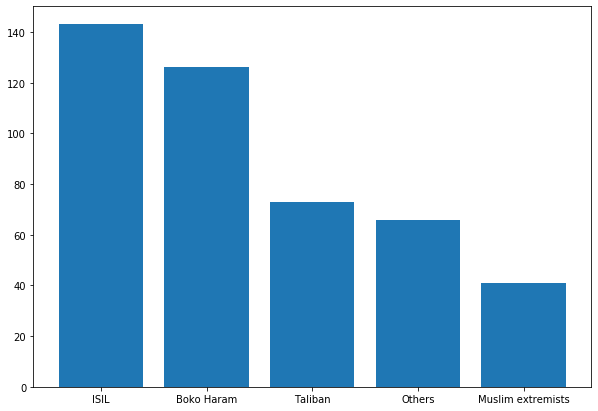

In [17]:
plt.bar(terr_df[(terr_df.targtype1_txt=="Religious Figures/Institutions")].gname.value_counts()[:5].index,terr_df[(terr_df.targtype1_txt=="Religious Figures/Institutions")].gname.value_counts()[:5].values)


<BarContainer object of 5 artists>

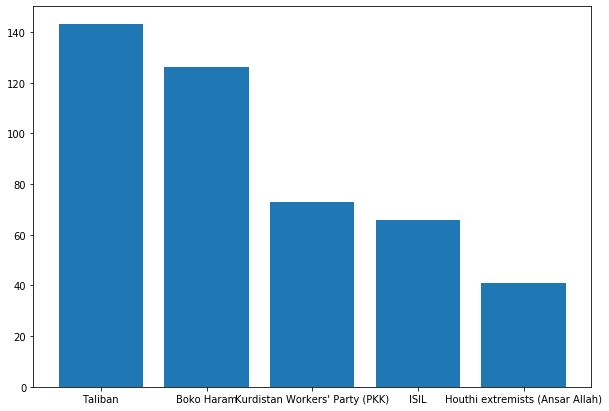

In [18]:
plt.bar(terr_df[(terr_df.targtype1_txt=="Educational Institution")].gname.value_counts()[:5].index,terr_df[(terr_df.targtype1_txt=="Religious Figures/Institutions")].gname.value_counts()[:5].values)


<BarContainer object of 5 artists>

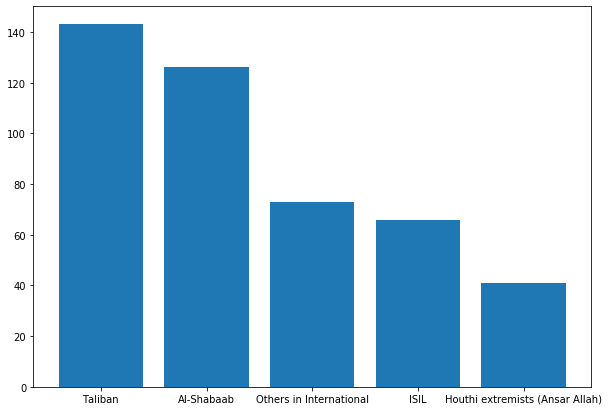

In [19]:
plt.bar(terr_df[(terr_df.targtype1_txt=="NGO")].gname.value_counts()[:5].index,terr_df[(terr_df.targtype1_txt=="Religious Figures/Institutions")].gname.value_counts()[:5].values)


<BarContainer object of 5 artists>

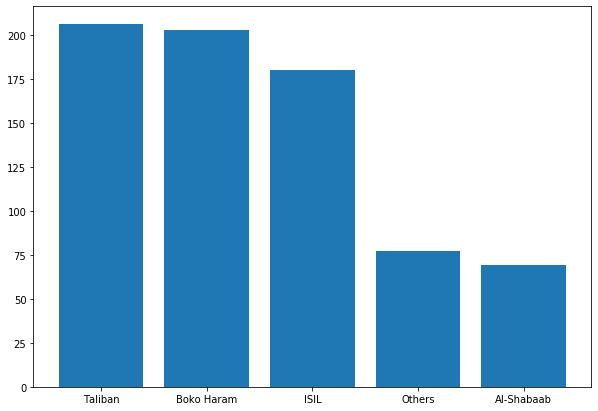

In [20]:
plt.bar(terr_df[(terr_df.targtype1_txt=="NGO")|(terr_df.targtype1_txt=="Educational Institution")|(terr_df.targtype1_txt=="Religious Figures/Institutions")].gname.value_counts()[:5].index,terr_df[(terr_df.targtype1_txt=="NGO")|(terr_df.targtype1_txt=="Educational Institution")|(terr_df.targtype1_txt=="Religious Figures/Institutions")].gname.value_counts()[:5].values)


### The above plots are for the top five terrrorist organisations that attack:
- Religious Figures/Institutions
- Educational Institutions
- NGO
- All the above
### Inference:
**As can be seen the top terrorist organisations remain almost same with change in the mentioned target type.**

In [21]:
terr_df.replace(to_replace =["Religious Figures/Institutions","Educational Institution","NGO"],  
                            value ="Peaceful Institutions/Organisations",inplace=True)

### Doing the same for other "targtype1_txt" values:

In [22]:
terr_df.replace(to_replace =["Government (Diplomatic)","Government (General)"],  
                            value ="Government",inplace=True)
terr_df.replace(to_replace =["Abortion Related"],  
                            value ="Other",inplace=True) 
terr_df.replace(to_replace =["Food or Water Supply","Transportation","Airports & Aircraft","Maritime","Journalists & Media","Telecommunication"],  
                            value ="Utilities",inplace=True) 
terr_df.replace(to_replace =["Violent Political Party","Terrorists/Non-State Militia"],  
                            value ="Enemy Combatants",inplace=True) 
terr_df.replace(to_replace =["Tourists"],  
                            value ="Private Citizens & Property",inplace=True)

### Moving on to 'weaptype1_txt':

In [23]:
terr_df.replace(to_replace=["Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)","Sabotage Equipment","Fake Weapons","Other"],value="Others",inplace=True)


In [24]:
a=np.where(terr_df.natlty1_txt != terr_df.country_txt,1,0 )
(a.sum()-terr_df.natlty1_txt.isnull().sum())/terr_df.shape[0]

0.08203753351206435

### Label Encoding:

In [25]:
terr_df['propextent_txt']=terr_df['propextent_txt'].fillna("Unknown",inplace=True)
terr_df.weapsubtype1_txt=terr_df.weapsubtype1_txt.fillna("Unknown")
d1={'Minor (likely < $1 million)' :1,'Unknown':0,'Major (likely > $1 million but < $1 billion)':2}
terr_df['propextent_txt'].replace(d1,inplace=True)
terr_df['propextent_txt'].fillna(0,inplace=True)
label_encoder = preprocessing.LabelEncoder()
terr_df.nkill.fillna(0,inplace=True)
terr_df.nwound.fillna(0,inplace=True)
terr_df['weaptype1_txt']= label_encoder.fit_transform(terr_df['weaptype1_txt']) 
terr_df['country_txt']= label_encoder.fit_transform(terr_df['country_txt']) 
terr_df['attacktype1_txt']= label_encoder.fit_transform(terr_df['attacktype1_txt']) 
terr_df['targtype1_txt']= label_encoder.fit_transform(terr_df['targtype1_txt']) 
terr_df['weapsubtype1_txt']= label_encoder.fit_transform(terr_df['weapsubtype1_txt'])
terr_df['city']=label_encoder.fit_transform(terr_df['city'])
terr_df['natlty1_txt']=label_encoder.fit_transform(terr_df['natlty1_txt'])
terr_df['gname']=label_encoder.fit_transform(terr_df['gname'])

In [26]:
terr_df.head()

,gname,idate,country_txt,city,attacktype1_txt,targtype1_txt,natlty1_txt,weaptype1_txt,weapsubtype1_txt,nkill,nwound,propextent_txt,ransomamt
0,3,20120101,46,3348,0,0,52,2,6,3.0,14.0,0,0.0
1,13,20120101,66,9165,2,3,80,2,10,4.0,3.0,0,0.0
2,3,20120101,46,3348,0,0,52,2,6,2.0,14.0,0,0.0
3,77,20120101,0,4792,2,3,42,2,25,0.0,0.0,0,0.0
4,19,20120101,24,8704,3,7,27,4,0,18.0,5.0,0,0.0


In [27]:
terr_df.gname.value_counts()

77    5599
28    5226
3     2350
16    1921
2     1303
      ... 
29      54
7       53
74      52
14      52
39      51
Name: gname, Length: 81, dtype: int64

 ### Inference:
 - It can be said that our target column is imbalanced, so we need to split the data into training and testing accordingly.

In [28]:
X=terr_df.drop(['gname'],axis=1)
y=terr_df['gname']
Xtrain,Xtest,ytrain,ytest=model_selection.train_test_split(X,y,test_size=0.2,stratify=y)

## Training and Testing part. 
 

### Target column tells us that this is a classification problem.
- So we apply classification algorithms and check there f1 scores.(As recall and precision both are equally important.)

In [28]:
def modelstats1(Xtrain,Xtest,ytrain,ytest):
    stats=[]
    modelnames=["Rf","DecisionTree","KNN","NB"]
    models=list()
    models.append(ensemble.RandomForestClassifier())
    models.append(tree.DecisionTreeClassifier())
    models.append(neighbors.KNeighborsClassifier())
    models.append(naive_bayes.GaussianNB())
    for name,model in zip(modelnames,models):
     model.fit(Xtrain,ytrain)
     trainprediction=model.predict(Xtrain)
     testprediction=model.predict(Xtest)
     scores=list()
     scores.append(name+"-train")
     scores.append(metrics.f1_score(ytrain,trainprediction,average='weighted')) # average = "weighted" is used since it is a multiclass classification
     stats.append(scores)
     scores=list()
     scores.append(name+"-test")
     scores.append(metrics.f1_score(ytest,testprediction,average='weighted'))
     stats.append(scores)
     colnames=["MODELNAME","F1"]
    return pd.DataFrame(stats,columns=colnames)


In [31]:
modelstats1(Xtrain,Xtest,ytrain,ytest)

D:\Machine learning\installconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Machine learning\installconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Machine learning\installconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Machine learning\installconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,MODELNAME,F1
0,Rf-train,0.991609
1,Rf-test,0.770174
2,DecisionTree-train,0.999764
3,DecisionTree-test,0.777898
4,KNN-train,0.573693
5,KNN-test,0.424467
6,NB-train,0.009917
7,NB-test,0.009219


### So we see that Random Forest (rf) and Decision Tree give a overfit model....which can be further improved
 - we use grid search CV  for hyperparameter tuning of the decision tree

In [33]:
h1 = {"min_samples_split":list(range(2,10)),"max_depth":list(range(10,20))}
scorer = metrics.make_scorer(metrics.f1_score, average = 'weighted')
gridobj = model_selection.GridSearchCV(estimator=tree.DecisionTreeClassifier(random_state=0),param_grid=h1)
gridobj.fit(Xtrain,ytrain)

D:\Machine learning\installconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=0,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
                         'min_samples_split': [2, 3, 4

In [34]:
gridobj.best_params_ 

{'max_depth': 14, 'min_samples_split': 3}

### Now applying hyperparameter tuning to Decision Tree

In [36]:
np.random.seed(42)
model=tree.DecisionTreeClassifier(max_depth=14,min_samples_split=3) 
model.fit(Xtrain,ytrain)
predtrain=model.predict(Xtrain)
predtest=model.predict(Xtest)
t=metrics.precision_score(ytrain,predtrain,average='weighted')
a=metrics.f1_score(ytest,predtest,average='weighted')
print("f1 score on testing set = ",a) 
print("f1 score on training set = ",t) 

f1 score on testing set =  0.7755100799797381
f1 score on training set =  0.8806886755449397


### We use grid search CV for hyperparameter tuning of the Random Forest

In [41]:
h1={'bootstrap': [True, False],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10]}
scorer = metrics.make_scorer(metrics.f1_score, average = 'weighted')
gridobj = model_selection.GridSearchCV(estimator=ensemble.RandomForestClassifier(random_state=0),param_grid=h1)
gridobj.fit(Xtrain,ytrain)

D:\Machine learning\installconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
D:\Machine learning\installconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Machine learning\installconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Machine learning\installconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Machine learning\in

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_gri

In [42]:
gridobj.best_params_ 

{'bootstrap': False, 'max_depth': 20, 'min_samples_split': 5}

In [43]:
np.random.seed(42)
model=ensemble.RandomForestClassifier(n_estimators=200,bootstrap= False, max_depth= 20, min_samples_split= 5)
model.fit(Xtrain,ytrain)
predtrain=model.predict(Xtrain)
predtest=model.predict(Xtest)
a=metrics.f1_score(ytest,predtest,average='weighted')
t=metrics.f1_score(ytrain,predtrain,average='weighted') 
print("f1 score on testing set = ",a) 
print("f1 score on training set = ",t)

f1 score on testing set =  0.8020857423531188
f1 score on training set =  0.9857354901273389


## Further efficiency of the model can be increased by Reccursive Feature Elimintaion


In [58]:
def rfe_fselection(Xtrain,Xtest,ytrain,ytest,model):
    np.random.seed(42)
    train=[]
    test=[]
    for i in range(2,10):
            rfecv=feature_selection.RFE(estimator=model,n_features_to_select=i)
            rfecv.fit(Xtrain,ytrain)
            cols=X.columns[rfecv.get_support()]
            X_=Xtrain[cols]
            X_t=Xtest[cols]
            rfecv.fit(X_,ytrain)
            train.append(metrics.f1_score(ytrain,rfecv.predict(X_),average='weighted'))
            test.append(metrics.f1_score(ytest,rfecv.predict(X_t),average='weighted'))
    plt.figure()
    plt.plot(np.arange(2,10,1),train)
    plt.plot(np.arange(2,10,1),test)
    plt.title("Optimal Number of Features (Random Forest) ")
    plt.legend(['train score', 'test score'], loc='upper left')
    plt.ylim(.5,.99)
    plt.show()

 - applying RFE in decision tree and plotting number of features vs f1 score

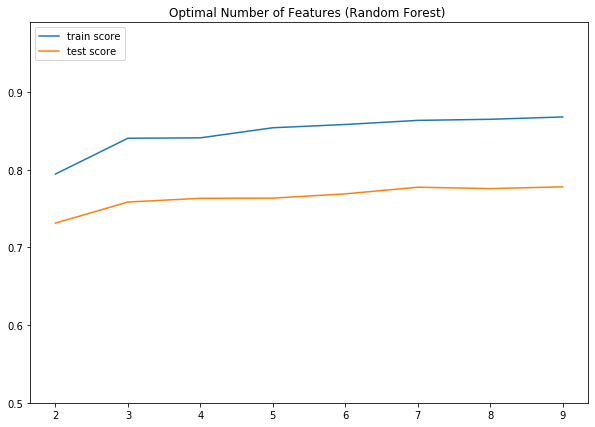

In [59]:
model=tree.DecisionTreeClassifier(max_depth=14,min_samples_split=3)
rfe_fselection(Xtrain,Xtest,ytrain,ytest,model)

 - From the above we infer that all the columns are equally important

## Applying RFE to random forest

D:\Machine learning\installconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Machine learning\installconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


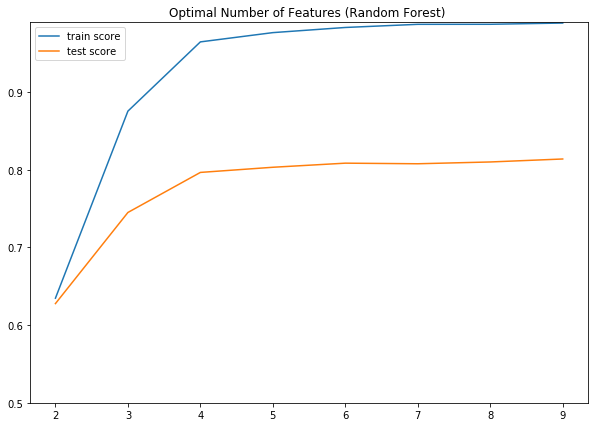

In [60]:
model=ensemble.RandomForestClassifier(n_estimators=200,bootstrap= False, max_depth= 20, min_samples_split= 5)
rfe_fselection(Xtrain,Xtest,ytrain,ytest,model)

## From the above it can be inferred that the model will give best prediction when 4 features are used.
 - Therefore extracting the best 4 features which affect the target columns the most

In [61]:
def get_importantf(X,y):
    np.random.seed(42)
    rf=ensemble.RandomForestClassifier(n_estimators=200,bootstrap= False, max_depth= 20, min_samples_split= 5)
    rf.fit(X,y)
    return pd.DataFrame(rf.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance',ascending=False)


In [62]:
get_importantf(Xtrain,ytrain)

,importance
country_txt,0.330821
natlty1_txt,0.274677
idate,0.114314
city,0.080634
weapsubtype1_txt,0.048362
targtype1_txt,0.044142
nkill,0.033517
nwound,0.025917
attacktype1_txt,0.024986
weaptype1_txt,0.019795


## Splitting the data and training the model on the 4 features 

In [28]:
X=terr_df[['country_txt','natlty1_txt','idate','city']]
y=terr_df['gname']
Xtrain,Xtest,ytrain,ytest=model_selection.train_test_split(X,y,test_size=0.2,stratify=y)

In [29]:
np.random.seed(42)
model=ensemble.RandomForestClassifier(n_estimators=200,bootstrap= False, max_depth= 20, min_samples_split= 5)
model.fit(Xtrain,ytrain)
predtrain=model.predict(Xtrain)
predtest=model.predict(Xtest)
a=metrics.f1_score(ytest,predtest,average='weighted')
t=metrics.f1_score(ytrain,predtrain,average='weighted') 
print("f1 score on testing set = ",a) 
print("f1 score on training set = ",t)

f1 score on testing set =  0.7982996367980737
f1 score on training set =  0.9639558727162472


In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
clf_final=OneVsRestClassifier(ensemble.RandomForestClassifier(n_estimators=200,bootstrap= False, max_depth= 20, min_samples_split= 5))
clf_final.fit(Xtrain,ytrain)

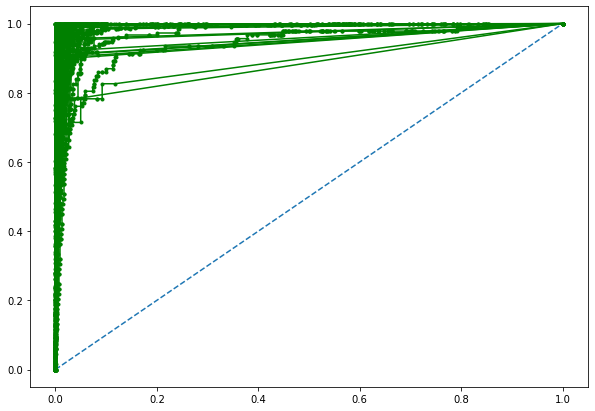

In [46]:
from sklearn.metrics import auc
y_score =clf_final.predict_proba(Xtest)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=y.nunique()
plt.plot([0,1],[0,1],linestyle='--')
for i in range(n_classes):
    fpr[i],tpr[i],thresh= roc_curve(np.array((ytest==i).astype('int')), y_score[:, i])
    roc_auc[i] =auc(fpr[i], tpr[i])
    plt.plot(fpr[i],tpr[i],marker='.',color='green')

# FURTHER IMPROVEMENTS:


In [68]:
a=np.where(terr_df.natlty1_txt != terr_df.country_txt,1,0 )
(a.sum()-terr_df.natlty1_txt.isnull().sum())/terr_df.shape[0]

0.8584450402144772

## 1.
#### It can be inferred that 91.5 % of the data in natlty1_txt and country_txt columns are same, but dropping one of the columns affects the accuracy of the model to a high degree.
### These two columns can be merged using feature extraction.

## 2.
### Systems with high computation power can tune the hyperparameters of the Random Forest to better extent.

In [37]:
terr_df.gname.nunique()

81